In [1]:
import sys
sys.path.insert(1, 'BATTERY_GITHUB')
import eval_utils
import pre_process_utils
# import BATTERY_GITHUB.pre_process_utils as pre_process_utils
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
from matplotlib import gridspec
params = {'legend.fontsize': 20,
          'figure.figsize': (9,6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':'xx-large',
         'axes.linewidth' : 2,
         'ytick.labelsize':'xx-large'}

plt.rcParams.update(params)

2024-05-04 15:26:14.348574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [78]:
import importlib
importlib.reload(eval_utils)

<module 'eval_utils' from '/baja/BATTERY_GITHUB/eval_utils.py'>

# Load Data

In [3]:
# HI DATA
data = np.load('Data/Battery/Load_data_big_sameT/processed_data_2post_60.npz')
Voltage_windows = data['Voltage_windows']
Cycles_windows = data['Cycles_windows']
Units_windows = data['Units_windows']
Current_windows = data['Current_windows']
Cycles_windows_2 = data['Cycles_windows_2']
HI_windows = data['HI_windows']
Temp_windows = data['Temp_windows']
Time_windows = data['Time_windows']



data = np.load('Data/Battery/Load_data_big_sameT/processed_data_2post_60_test.npz')
Voltage_windows_test = data['Voltage_windows_test']
Cycles_windows_test = data['Cycles_windows_test']
Units_windows_test = data['Units_windows_test']
Current_windows_test = data['Current_windows_test']
Cycles_windows_2_test = data['Cycles_windows_2_test']
HI_windows_test = data['HI_windows_test']   
Temp_windows_test = data['Temp_windows_test']
Time_windows_test = data['Time_windows_test']

In [4]:
Y_windows = pre_process_utils.RUL_maker(Cycles_windows,Units_windows).reshape(-1,1)
Y_windows_test = pre_process_utils.RUL_maker(Cycles_windows_test,Units_windows_test).reshape(-1,1)

HI_windows = HI_windows[:,0]
HI_windows_test = HI_windows_test[:,0]

#Convert to SOH%
MANUFACTURE_CAPACITY = 2.1
HI_windows = HI_windows/MANUFACTURE_CAPACITY
HI_windows_test = HI_windows_test/MANUFACTURE_CAPACITY

In [5]:
V_T = np.concatenate((Voltage_windows, Temp_windows), axis=-1)
V_T_test = np.concatenate((Voltage_windows_test,Temp_windows_test),axis = -1)

In [6]:
print(Voltage_windows.shape,Voltage_windows_test.shape)

(6474, 2260, 1) (2295, 2260, 1)


# Ground Truth

In [15]:
hh_scaled_thresholded,units_hh,cycles_hh = eval_utils.smooth_per_cycle(HI_windows_test,Cycles_windows_2_test[:,0],Units_windows_test)
y_z =  eval_utils.smooth_per_cycle(Y_windows_test,Cycles_windows_2_test[:,0],Units_windows_test)[0]
hh_scaled_thresholded = hh_scaled_thresholded*100

print(eval_utils.monotonicity(hh_scaled_thresholded,units_hh))
print(eval_utils.trend_spearman(hh_scaled_thresholded,cycles_hh,units_hh))
print(eval_utils.failure_consistency(hh_scaled_thresholded,units_hh))
print(eval_utils.mutual_information(hh_scaled_thresholded.reshape(-1,1),y_z.reshape(-1,1),units_hh))

0.9705882352941176
0.999484004127967
0.966653664104942
0.6548666905150431


# Proposal

In [21]:
def plot_unit():
    Unit = 20
    run_id = 0
    hh ,units_smooth, cycles_smooth = eval_utils.smooth_per_cycle(HI_windows_test,Cycles_windows_2_test[:,0],Units_windows_test)
    hh = hh*100

    t = Time_windows_test[:,0]
    t = eval_utils.smooth_per_cycle(t,Cycles_windows_2_test[:,0],Units_windows_test)[0]
    t = t/3600/24


    idx2 = np.ravel(units_smooth==Unit)

    fig = plt.figure()
    plt.plot(t[idx2],z_test[run_id][idx2],'#8BC53F',label = r'$hi_{p}^C$')
    plt.plot(t[idx2],hh[idx2],'#3FC5BC',label = r'$hi_{gt}$')

    plt.fill_between(t[idx2],(z_test[run_id][idx2]-z_test_std[run_id][idx2]), 
                            (z_test[run_id][idx2]+z_test_std[run_id][idx2]), alpha = 0.5,color = '#8BC53F',label='1 std.')
    plt.legend()
    plt.xlabel('Time (Days)')
    plt.ylabel('SOH (%)')
    plt.ylim(55,110)
    plt.xlim(0,130)
    plt.yticks(np.arange(55, 115, 10))
    plt.show()

In [75]:
class C_constraint(tf.keras.layers.Layer):   # Inheritance class
    def __init__(self,alpha,**kwargs):  
        super().__init__(**kwargs)
        self.alpha = alpha
        
    def call(self, inputdata):
        x, t = inputdata
        x_mu = tf.reduce_mean(x)
        t_mu = tf.reduce_mean(t)
        cov = tf.reduce_sum((x-x_mu)*(t-t_mu))
        std = tf.math.pow(tf.reduce_sum((x-x_mu)**2),0.5) * tf.math.pow(tf.reduce_sum((t-t_mu)**2),0.5)
        loss = cov/std
        loss = tf.reduce_mean(loss)
        
        self.add_loss(self.alpha*loss)
        self.add_metric(loss, aggregation='mean', name='l1')
        return x
    
    
class NG_constraint(tf.keras.layers.Layer):   # Inheritance class
    def __init__(self,alpha,**kwargs):  
        super().__init__(**kwargs)
        self.alpha = alpha
        
    def call(self, inputdata):
        x,t = inputdata
        x_diff = x[1:]-x[:-1]
        t_diff = t[1:]-t[:-1]
        grad = x_diff/t_diff
        loss = tf.reduce_sum(tf.math.maximum(tf.constant(0.0),grad))
        self.add_loss(self.alpha*loss)
        self.add_metric(loss, aggregation='mean', name='Grad')
        
        
        return x
    
class F_constraint(tf.keras.layers.Layer):   # Inheritance class
    def __init__(self,alpha,**kwargs):  
        super().__init__(**kwargs)
        self.alpha = alpha
        
        self.A = 3.24689126e-04
        self.B = 6.75139693e-01
        self.C = 1.02044605e+00
        self.BETA = 3.5
        self.P = 0.5
        
    def call(self, inputdata):
        x, t = inputdata
        HI = self.C - ((t * (-np.log(1 - self.P))**(-1/self.BETA))*self.A)**self.B
        mask = tf.math.less(HI,0)
        HI = tf.where(mask,0.0,HI)
        loss = tf.reduce_mean(tf.abs(x-HI))
        
        self.add_loss(self.alpha*loss)
        self.add_metric(loss, aggregation='mean', name='l1')
        return x
    
def H_index_Proposal_CNN(latent_dims,Window_size = 100,z_size=1,cnn_dim = 85,stride = 2,alpha = 1,constraint = "C"):
    
    x_dim = 2
    w_dim = 1
    
    inpX = tf.keras.layers.Input(shape=(Window_size,x_dim),name = 'InpX')
    inputT = tf.keras.layers.Input(shape=(1,),name = 'inpT')
    inpW = tf.keras.layers.Input(shape=(Window_size,w_dim),name = 'inpW')
    x = inpX
    w_in = inpW
    
    for i in latent_dims:
            # x = tf.keras.layers.Dense(i,activation='relu')(x)
        x=tf.keras.layers.Conv1D(i,cnn_dim,stride,activation='relu',padding = 'same')(x)

    x = tf.keras.layers.Flatten(name = 'flatten')(x)
    x = tf.keras.layers.Dense(z_size,name="Z")(x) #activity_regularizer=regularizers.l1(10e-5)
    if constraint == 'C':
        x = C_constraint(alpha, name='constrained')([x, inputT])
    elif constraint == 'NG':
        x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x), name='Z_after')(x)
        x = NG_constraint(alpha, name='constrained')([x, inputT])
    elif constraint == 'F':
        x = F_constraint(alpha, name='constrained')([x, inputT])
    else:
        raise ValueError("Invalid constraint type. Must be 'C', 'NG', or 'F'") 
    x = tf.keras.layers.RepeatVector(Window_size,name='repeat')(x)
    
    x = tf.keras.layers.Concatenate(axis  =-1)([x,w_in])
    for i in reversed(latent_dims):
        x = tf.keras.layers.Conv1D(i,cnn_dim,strides=1,activation='relu',padding = 'same')(x)
    x=tf.keras.layers.Dense(x_dim,name='X')(x)   
       
    model = tf.keras.models.Model([inpX,inputT,inpW],x)
    return model

## C constraint

In [19]:
constraint = 'C'
layers=  [128,64,16]
Window_size = Voltage_windows.shape[1]
model = H_index_Proposal_CNN(layers,Window_size,constraint = constraint)

In [60]:
result,z_train,z_train_std,z_test,z_test_std = eval_utils.train_and_evaluate_proposed_model(V_T, Current_windows, Cycles_windows,Cycles_windows_2, Units_windows, Y_windows,HI_windows,
                                                                                                    V_T_test, Current_windows_test, Cycles_windows_test,Cycles_windows_2_test, Units_windows_test, Y_windows_test,HI_windows_test,
                                             model,runs = 1, epochs = 1, batch_size=128,learning_rate = 0.0001,reset_weights = False)

RUN#:  0
reset_weights
18/18 [==============================] - 1s 28ms/step
{'MAE_TR': [4.000386996771878], 'MAPE_TR': [5.416261026392754], 'M_TR': [0.8802910052910052], 'T_TR': [0.9962440573390903], 'FC_TR': [0.913586], 'MI_TR': [0.7184108964523669], 'MAE_TS': [4.340547999486265], 'MAPE_TS': [5.877311176326247], 'M_TS': [0.8436041083099907], 'T_TS': [0.9946679868119497], 'FC_TS': [0.78046674], 'MI_TS': [0.6309531446006061], 'TIME': [19.095320463180542], 'I': [0]}


In [65]:
pd.DataFrame(result)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,4.000387,5.416261,0.880291,0.996244,0.913586,0.718411,4.340548,5.877311,0.843604,0.994668,0.780467,0.630953,19.09532,0


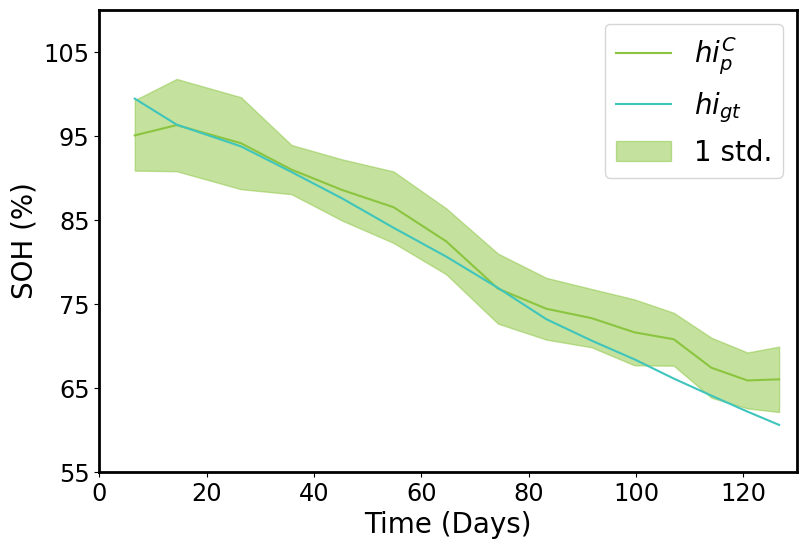

In [64]:
plot_unit()

## NG

In [92]:
constraint = 'NG'
layers=  [128,64,16]
Window_size = Voltage_windows.shape[1]
model = H_index_Proposal_CNN(layers,Window_size,constraint = constraint)

In [93]:
result,z_train,z_train_std,z_test,z_test_std = eval_utils.train_and_evaluate_proposed_model(V_T, Current_windows, Cycles_windows,Cycles_windows_2, Units_windows, Y_windows,HI_windows,
                                                                                                    V_T_test, Current_windows_test, Cycles_windows_test,Cycles_windows_2_test, Units_windows_test, Y_windows_test,HI_windows_test,
                                             model,runs = 1, epochs = 10, batch_size=128,learning_rate = 0.0001,shuffle=False,reset_weights = True)

RUN#:  0
reset_weights
Epoch 1/10
51/51 [==============================] - 17s 264ms/step - loss: 1.1395 - mae: 0.0795 - Grad: 1.0623
Epoch 2/10
51/51 [==============================] - 13s 256ms/step - loss: 0.2462 - mae: 0.0552 - Grad: 0.1930
Epoch 3/10
51/51 [==============================] - 13s 255ms/step - loss: 0.1460 - mae: 0.0387 - Grad: 0.1071
Epoch 4/10
51/51 [==============================] - 13s 255ms/step - loss: 0.1162 - mae: 0.0372 - Grad: 0.0787
Epoch 5/10
51/51 [==============================] - 14s 262ms/step - loss: 0.0985 - mae: 0.0349 - Grad: 0.0633
Epoch 6/10
51/51 [==============================] - 13s 254ms/step - loss: 0.0924 - mae: 0.0357 - Grad: 0.0564
Epoch 7/10
51/51 [==============================] - 13s 253ms/step - loss: 0.0793 - mae: 0.0352 - Grad: 0.0438
Epoch 8/10
51/51 [==============================] - 13s 259ms/step - loss: 0.0863 - mae: 0.0347 - Grad: 0.0513
Epoch 9/10
51/51 [==============================] - 13s 255ms/step - loss: 0.0681 - mae: 

In [94]:
pd.DataFrame(result)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,8.764298,11.022506,0.317146,0.411533,0.286125,0.42653,10.098626,13.332015,0.414846,0.193309,0.421211,0.458051,140.252345,0


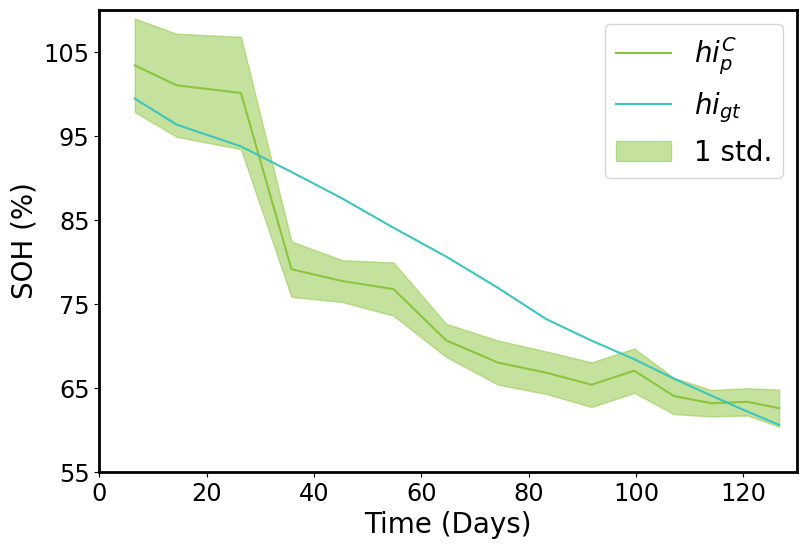

In [95]:
plot_unit()

## F

In [67]:
constraint = 'F'
layers=  [128,64,16]
Window_size = Voltage_windows.shape[1]
model = H_index_Proposal_CNN(layers,Window_size,constraint = constraint)

In [68]:
result,z_train,z_train_std,z_test,z_test_std = eval_utils.train_and_evaluate_proposed_model(V_T, Current_windows, Cycles_windows,Cycles_windows_2, Units_windows, Y_windows,HI_windows,
                                                                                                    V_T_test, Current_windows_test, Cycles_windows_test,Cycles_windows_2_test, Units_windows_test, Y_windows_test,HI_windows_test,
                                             model,runs = 1, epochs = 20, batch_size=128,learning_rate = 0.0001,reset_weights = False)

RUN#:  0
reset_weights
Epoch 1/20
51/51 [==============================] - 16s 256ms/step - loss: 0.2487 - mae: 0.0753 - l1: 0.1727
Epoch 2/20
51/51 [==============================] - 13s 256ms/step - loss: 0.1253 - mae: 0.0485 - l1: 0.0768
Epoch 3/20
51/51 [==============================] - 13s 255ms/step - loss: 0.1047 - mae: 0.0413 - l1: 0.0634
Epoch 4/20
51/51 [==============================] - 13s 255ms/step - loss: 0.0968 - mae: 0.0364 - l1: 0.0604
Epoch 5/20
51/51 [==============================] - 13s 255ms/step - loss: 0.0944 - mae: 0.0345 - l1: 0.0599
Epoch 6/20
51/51 [==============================] - 13s 255ms/step - loss: 0.0915 - mae: 0.0336 - l1: 0.0578
Epoch 7/20
51/51 [==============================] - 13s 255ms/step - loss: 0.0914 - mae: 0.0332 - l1: 0.0582
Epoch 8/20
51/51 [==============================] - 13s 255ms/step - loss: 0.0896 - mae: 0.0326 - l1: 0.0569
Epoch 9/20
51/51 [==============================] - 13s 255ms/step - loss: 0.0873 - mae: 0.0319 - l1: 0.0

In [69]:
print(pd.DataFrame(result))

    MAE_TR   MAPE_TR      M_TR      T_TR     FC_TR     MI_TR    MAE_TS  \
0  3.79882  5.167658  0.750908  0.987439  0.903742  0.671295  3.616044   

    MAPE_TS      M_TS      T_TS     FC_TS     MI_TS        TIME  I  
0  4.908097  0.711671  0.991224  0.826743  0.620171  268.124846  0  


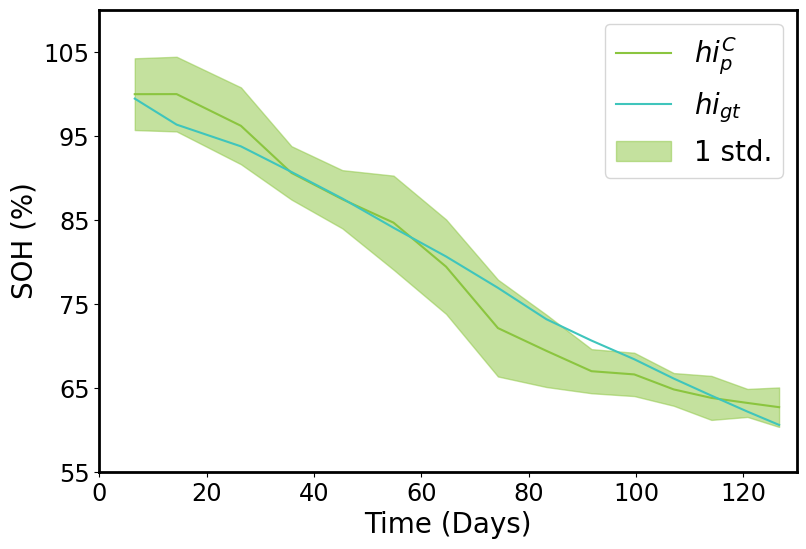

In [70]:
plot_unit()